<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:

In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

Además se integran algunas funciones que serán utilzazas en este 

In [2]:
import matplotlib.pyplot as plt
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()


In [3]:
def critical(train,test):
    error_min = 9999999
    error=0
    index = 0
    for i in range(len(train)):
        error = abs(train[i] - test[i])
        if error<error_min:
            error_min = error
            index=i
    return error_min,index;

Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.


> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [4]:
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x= "trip_duration",data=df)
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 20
plt.xticks(rotation=70)

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

In [5]:

df = df[(df['trip_duration']<=10000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1456521 non-null object
vendor_id             1456521 non-null int64
pickup_datetime       1456521 non-null object
dropoff_datetime      1456521 non-null object
passenger_count       1456521 non-null int64
pickup_longitude      1456521 non-null float64
pickup_latitude       1456521 non-null float64
dropoff_longitude     1456521 non-null float64
dropoff_latitude      1456521 non-null float64
store_and_fwd_flag    1456521 non-null object
trip_duration         1456521 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 133.3+ MB


In [6]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado. 

In [7]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [8]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)


y_train=y_train[0:100000]
y_test = y_test[0:100000]
X_train_scaled = scaler.transform(X_train)
X_train_scaled = X_train_scaled[0:100000]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled[0:100000]


> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

ERROR RMSLE de training:  0.0005953344550069709
ERROR RMSLE de test:  0.5406477972142476
tiempo bloque 5.954071521759033


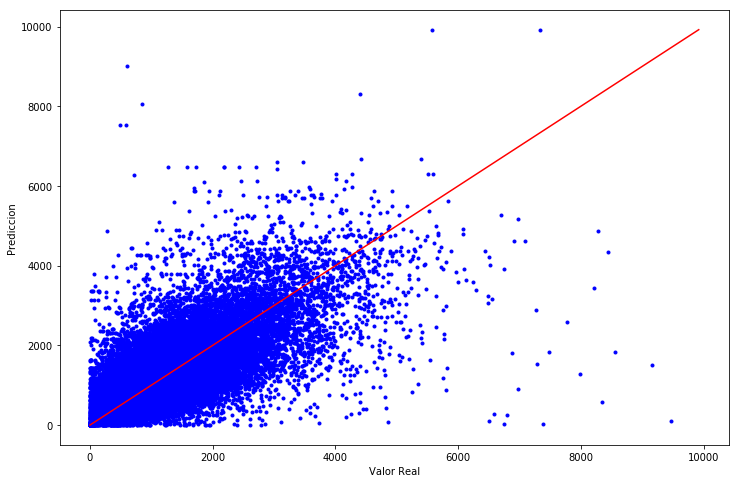

In [9]:
from sklearn.tree import DecisionTreeRegressor
import time
start = time.time()
model =DecisionTreeRegressor()#SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))
end = time.time()
print("tiempo bloque", end-start)
graficar_predicciones(y_test,model.predict(X_test_scaled))

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

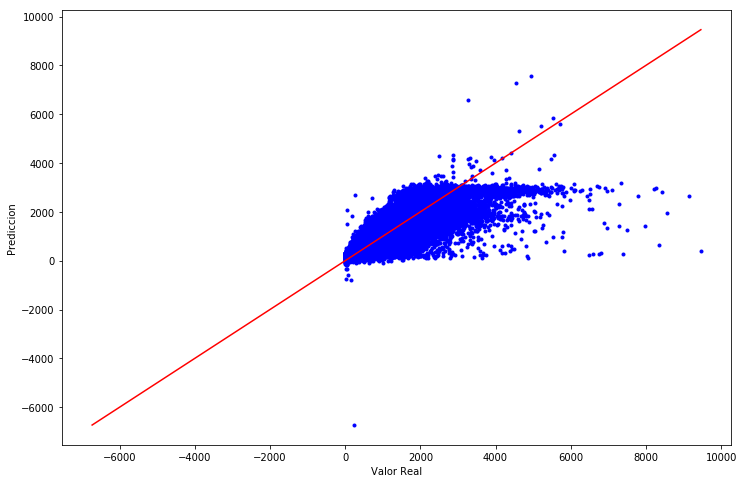

In [12]:

graficar_predicciones(y_test,model.predict(X_test_scaled))

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import time
error_ltrain = []
error_ltest = []
lx =[]
ltime = []
for i in range(0,1000):
    start = time.time()
    model =DecisionTreeRegressor(max_depth=i+1)#SVM, Decision Trees or Neural Network
    model.fit(X_train_scaled,y_train)
    error_train =  rmsle(model.predict(X_train_scaled),y_train)
    error_test =  rmsle(model.predict(X_test_scaled),y_test)
    error_ltrain.append(error_train)
    error_ltest.append(error_test)
    lx.append(i)
    end = time.time()
    ltime.append(end-start)



In [ ]:
import matplotlib.pyplot as plt

plt.plot(lx,ltime)#Esto es para medir el tiempo, solo por curiosidad.

In [ ]:
plt.plot(lx,error_ltrain)
plt.plot(lx,error_ltest)

In [ ]:
critical(error_ltrain,error_ltest)

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

Sinceramente no consideraria el pre procesamiento realizado par las fechas anteriormente para hacer pasar los atributos por cambios categoricos para la hora, epoca y otras cosas.

In [ ]:
df1 = pd.read_csv("train.csv")#Tomo los datos denuevo para hacer otro preprocesamiento
df1 = df1[(df1['trip_duration']<=10000)]

La solución que se desea implementar consiste en considerar la mayor cantidad de variables que podrían influir como por ejemplo el año para despues pasar por una selección de atributos a través de Z score

In [ ]:
from geopy.distance import great_circle
import numpy as np

"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar_2(df1):
    df1.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df1['hour'] = pd.to_datetime(df1['pickup_datetime']).dt.hour
    df1['hour'] = pd.to_numeric(df1['hour'])
    df1['cday'] = pd.to_datetime(df1['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df1['cday'] = pd.to_numeric(df1['cday'])
    df1['month'] = pd.to_datetime(df1['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df1['month'] = pd.to_numeric(df1['month'])
    df1['year'] = pd.to_datetime(df1['pickup_datetime']).dt.year #1:enero, 12: diciembre
    df1['year'] = pd.to_numeric(df1['month'])
    
    """Feature Generation"""
    df1['distancia_viaje'] = np.sqrt( np.square(df1['pickup_longitude']-df1['dropoff_longitude']) 
                                    + np.square(df1['pickup_latitude']-df1['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df1['pickup_latitude'].values[i], 
                                 df1['pickup_longitude'].values[i],
                                 df1['dropoff_latitude'].values[i],
                                 df1['dropoff_longitude'].values[i]) for i in range(len(df1['pickup_latitude']))]
    df1['distancia_viaje_km'] = distancia_real_aprox
    df1['grado_direccion'] = [ grado(df1['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df1['pickup_longitude'].values[i],
                                 df1['dropoff_latitude'].values[i],
                                 df1['dropoff_longitude'].values[i]) for i in range(len(df1['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df1['season'] = [ seasons[df1['month'].values[i] - 1] for i in range(len(df1['month'])) ]  #agregar temporada
    df1['holiday'] = df1['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df1.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df1["holiday"] = df1["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df1.select_dtypes(['category']).columns
    df1[cat_columns] = df1[cat_columns].apply(lambda x: x.cat.codes)
preprocesar_2(df1)

#

X = df1.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)


y_train=y_train[0:100000]
y_test = y_test[0:100000]
X_train_scaled = scaler.transform(X_train)
X_train_scaled = X_train_scaled[0:100000]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled[0:100000]

No consideró categorizar los años,pues  si la regresión lineal estuviese en un caso ideal, sería similar a un interpolador de lagrange [Link](https://en.wikipedia.org/wiki/Lagrange_polynomial). Esto considera el supuesto de que si se comportase de manera similar, nuestra función f:R->R sería de la forma "f(x) = a(x-2015)+b(x-2016)+c(x-2017)+ j" con j una constante que simbolize el ruido que hay entre los distintos años. No se considera un grado mayor a 1 del polinomio por la naturaleza del problema.

Además otra alternativa a considerar es la eliminacion de datos anomalos en la regresión, es decir, viajes que exista certeza alguna de que haya salido algo mal en cuanto al registro. Esto considera casos que se disparan en tiempo, ya que esto se midió al principio, sino aquellos tiempos en los cuales dada una ubicacion relativa, tarde más de lo quedebería tomando en cuenta un retraso que dependa tambien de la distancia recorrida.

Tambien cabe destacar que a pesar de tener toda la informacion respecto al viaje en taxi, no se considera la información del pasajero, por lo que las siguientes situaciones podrían ser las que afectan a nuestros resultados:

- Malas mediciones:
- Del Conductor
    - Ocacionadas por el conductor
    - por considerar o no subir-bajar equipaje
    - cada conductor conduce diferente ()
- Situacionales:
    - Accidentes
    - congestion vehicular
    - fechas especiales
- Del pasajero:
    - Se baja antes
    -lleva equipaje 
    
por lo que existe una manera de reducir el error comparandolo con el trayecto más similar y deshechar aquellos datos que generen más ruido.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import time
start = time.time()
error_min = 9999
error = 9999
depth = 1
for i in range(101):
    model =DecisionTreeRegressor(splitter = "best",max_depth=i+1)#SVM, Decision Trees or Neural Network
    model.fit(X_train_scaled,y_train)
   # rmsle(model.predict(X_train_scaled),y_train)
    error = rmsle(model.predict(X_test_scaled),y_test)
    if error<error_min:
        depth = i+1
        error_min = error

        
model =DecisionTreeRegressor(splitter = "best",max_depth=depth)#SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)  
print("Resultado optimo con parametro max_depth = ",depth)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))        
        
end = time.time()
print("tiempo bloque", end-start)
graficar_predicciones(y_test,model.predict(X_test_scaled))

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.

In [ ]:
#mi proposicion para esta parte es trabsformar todo a horas o simplemente categorizar los horarios 

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.

In [ ]:
"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]